# Supply Trend 

This is a very useful example combining functionality from our *Vessel*, *Port*, *Voyages*, *Market Rates* and *Historical Tonnage List* APIs. The aim is to plot a supply trend with superimposed predicted market rates for getting a more hollistic insight of the market behaviour during the range of interest from a specific load port and vessel class.

## Setup

Install the Signal Ocean SDK:

In [ ]:
pip install signal-ocean

Import required libraries / APIs / packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, time

from signal_ocean import PortAPI, VesselClassAPI, PortFilter, VesselClassFilter, MarketRatesAPI, Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.historical_tonnage_list import HistoricalTonnageListAPI, VesselFilter, PushType, MarketDeployment, CommercialStatus, VesselSubclass, IndexLevel

Fill in your personal SignalOcean API subscription key acquired <a href="https://apis.signalocean.com/profile" target="_blank">here</a> and open a connection:

In [ ]:
signal_ocean_api_key = '' #fill with your subscription key
connection = Connection(signal_ocean_api_key)

Instantiate connections for all imported APIs:

In [3]:
port_api = PortAPI(connection)
vessel_class_api = VesselClassAPI(connection)
voyages_api = VoyagesAPI(connection)
htl_api = HistoricalTonnageListAPI(connection)
mr_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend superimposed with the predicted market rates, we need to filter the query by specifying the following parameters:
1. **vessel_class:** Class of the Vessel.
2. **load_port:** The loading port.
3. **days_back:** Time window for plotting the supply trend, with current date as end date.
4. **max_eta:** Estimated Time of Arrival window for available vessels to reach the loading port.
5. **push_type:** Pushed status, if available from the emails in your account.
6. **market_deployment:** Market deployment, based on SignalOcean information. 
7. **commercial_status:** Commercial status of the vessel at each point in time.
8. **trade:** The type of product that the vessel is classified to carry.
9. **ais_since:** How many days since the vessel has transmitted its AIS.
10. **route_description:** The route of interest with available market rates.

In [4]:
vessel_class = 'Aframax'
load_port = 'Ceyhan'
days_back = 90                  
max_eta = 10                     
    
push_type = [PushType.PUSHED_POSS, PushType.PUSHED]
market_deployment = [MarketDeployment.RELET, MarketDeployment.SPOT]
commercial_status = [CommercialStatus.AVAILABLE, CommercialStatus.ON_SUBS, CommercialStatus.FAILED, CommercialStatus.CANCELLED]
trade = VesselSubclass.DIRTY
ais_since = 5

route_description = 'Afra - Med'

In [5]:
today = datetime.utcnow().date()
start_date = today - timedelta(days=days_back)
end_date = today

For more information, the user can refer to the respective documentation in the <a href="https://signaloceansdk.github.io/SignalSDK/historical_tonnage_list/" target="_blank">Historical Tonnage List</a> and  <a href="https://signaloceansdk.github.io/SignalSDK/market_rates/" target="_blank">Market Rates</a> API sections.

Instantiate the vessel filter based on the specified parameters:

In [6]:
vessel_filter = VesselFilter(
    push_types=push_type,
    market_deployments=market_deployment,
    commercial_statuses=commercial_status,
    vessel_subclass=trade,
    latest_ais_since=ais_since
)

### Apply filters and extract tonnage list

Get information about the specified vessel class and load port by utilising the <a href="https://signaloceansdk.github.io/SignalSDK/vessels/#signal_ocean.vessels.vessels_api.VesselsAPI.get_vessel_classes" target="_blank">VesselClassAPI</a>, <a href="https://signaloceansdk.github.io/SignalSDK/port_expenses/#signal_ocean.port_expenses.port_expenses_api.PortExpensesAPI.get_ports" target="_blank">PortAPI</a> as well as VesselClassFilter and PortFilter in order to search for entries best matching the input parameters.

In [7]:
vessel_class = vessel_class_api.get_vessel_classes(VesselClassFilter(name_like=vessel_class))[0] 
port = port_api.get_ports(PortFilter(name_like=load_port))[0]

Call the Historical Tonnage List API to import the data:

In [8]:
htl = htl_api.get_historical_tonnage_list(
    loading_port=port,
    vessel_class=vessel_class,
    laycan_end_in_days=max_eta,
    start_date=start_date,
    end_date=end_date,
    vessel_filter=vessel_filter 
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend

name vessel_class  \
date                      imo                                           
2021-08-18 00:00:00+00:00 9395331               Corossol      Aframax   
                          9382762         Minerva Sophia      Aframax   
                          9305611             Promitheas      Aframax   
                          9823041         Alfa Finlandia      Aframax   
                          9752797           Alfa Alandia      Aframax   
...                                                  ...          ...   
2021-05-20 00:00:00+00:00 9389966                 Alexia      Aframax   
                          9514169          Green Warrior      Aframax   
                          9334038  Yasa Golden Bosphorus      Aframax   
                          9420617         Zarifa Aliyeva      Aframax   
                          9693068                Abliani      Aframax   

                                  ice_class  year_built  deadweight  \
date                      imo                                         
2021-08-18 00:00:00+00:00 9395331       NaN        2010      106898   
                          9382762       NaN        2009      115748   
                          9305611        1A        2006      117055   
                          9823041       NaN        2019      109089   
                          9752797       NaN        2016      106324   
...                                     ...         ...         ...   
2021-05-20 00:00:00+00:00 9389966       NaN        2009      107574   
                          9514169       NaN        2011      104626   
                          9334038       NaN        2007      115867   
                          9420617       NaN        2010      107507   
                          9693068       NaN        2015      109999   

                                   length_overall  breadth_extreme subclass  \
date                      imo                                                 
2021-08-18 00:00:00+00:00 9395331          243.80               42    Dirty   
                          9382762          248.96               44    Dirty   
                          9305611          249.90               44    Dirty   
                          9823041          228.60               44    Dirty   
                          9752797          228.00               42    Dirty   
...                                           ...              ...      ...   
2021-05-20 00:00:00+00:00 9389966          243.80               42    Dirty   
                          9514169          228.60               42    Dirty   
                          9334038          248.92               44    Dirty   
                          9420617          243.80               43    Dirty   
                          9693068          249.90               44    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2021-08-18 00:00:00+00:00 9395331                            Spot   
                          9382762                            Spot   
                          9305611                            Spot   
                          9823041                            Spot   
                          9752797                            Spot   
...                                                           ...   
2021-05-20 00:00:00+00:00 9389966                            Spot   
                          9514169                            Spot   
                          9334038                            Spot   
                          9420617                           Relet   
                          9693068                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2021-08-18 00:00:00+00:00 9395331             Pushed POSS  ...   
                          9382762                  Pus

### Get daily market rates for the vessel route 

In [9]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = mr_api.get_routes(vessel_class_id=vessel_class.id)
    for i,v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]

In [10]:
mr_route = return_selected_route(vessel_class, route_description)
market_rates = mr_api.get_market_rates(start_date, route_id=mr_route.id, vessel_class_id=vessel_class.id, end_date=end_date)
market_rates = pd.DataFrame([vars(vr) for vr in market_rates]) 
market_rates['rate_date'] = pd.to_datetime(market_rates['rate_date'])
market_rates.set_index('rate_date', inplace=True) 
market_rates

,route_id,rate_value,unit,vessel_class_id
rate_date,,,,
2021-05-20,R1,95.0,WS,86
2021-05-21,R1,92.5,WS,86
2021-05-22,R1,92.5,WS,86
2021-05-23,R1,92.5,WS,86
2021-05-24,R1,90.0,WS,86
...,...,...,...,...
2021-08-14,R1,87.5,WS,86
2021-08-15,R1,87.5,WS,86
2021-08-16,R1,87.5,WS,86


## Plot: daily supply trend with market rates

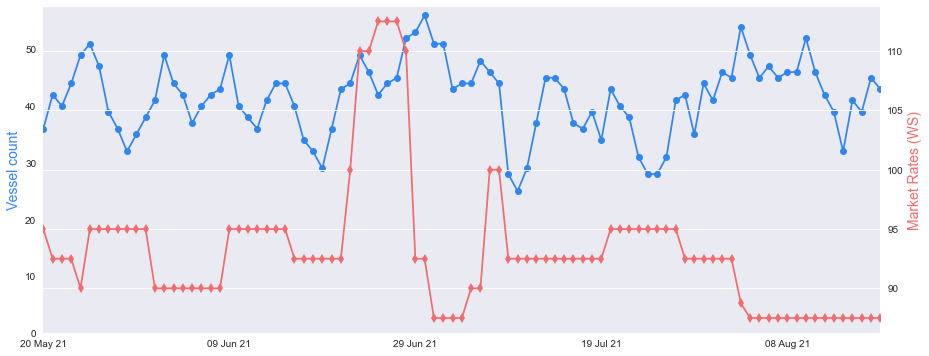

In [11]:
plt.style.use('seaborn')
fig, axs = plt.subplots(figsize=(15,6))

supply_trend = htl_for_supply_trend.groupby(IndexLevel.DATE, sort=True).size()
supply_trend.index = supply_trend.index.strftime('%d %b %y')

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs, x='date', color='#3086EF', marker='o')
supply_plot.set_ylabel('Vessel count', color=plt.gca().lines[-1].get_color(), fontsize=14)
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
market_rates.index = market_rates.index.strftime('%d %b %y')
mr_plot = market_rates.plot(ax=axs, y='rate_value', secondary_y=True, color='#F06C6E', marker='d')
mr_plot.set_ylabel('Market Rates (WS)', color=plt.gca().lines[-1].get_color(), fontsize=14)

axs.set_xlim(0, len(supply_trend)-1)
axs.set_xlabel('')
axs.get_legend().remove()

## Point to Point comparison

Workflow to compare two different points in time (days) in order to solve discrepancies.
Specify dates to compare:

In [12]:
today = datetime.utcnow().date() # point A
two_days_ago = today - timedelta(days=2) # point B

In [13]:
date_values = htl_for_supply_trend.index.get_level_values('date').date

if not any(date_values == today):
    raise SyntaxError('Today is not within imported date values.')
elif not any(date_values == two_days_ago):
    raise SyntaxError('Two days ago is not within imported date values.')
        
vessels_in_today = htl_for_supply_trend.loc[(date_values == today)]
vessels_in_two_days_ago = htl_for_supply_trend.loc[(date_values == two_days_ago)]

### Intersection of Vessel IMOs

In [14]:
intersection = pd.merge(vessels_in_today.add_suffix('_IN_TODAY'), vessels_in_two_days_ago.add_suffix('_IN_2DAYS_AGO'), how ='inner', on ='imo')
intersection

,name_IN_TODAY,vessel_class_IN_TODAY,ice_class_IN_TODAY,year_built_IN_TODAY,deadweight_IN_TODAY,length_overall_IN_TODAY,breadth_extreme_IN_TODAY,subclass_IN_TODAY,market_deployment_point_in_time_IN_TODAY,push_type_point_in_time_IN_TODAY,...,commercial_operator_point_in_time_IN_2DAYS_AGO,commercial_status_point_in_time_IN_2DAYS_AGO,eta_point_in_time_IN_2DAYS_AGO,latest_ais_point_in_time_IN_2DAYS_AGO,open_prediction_accuracy_point_in_time_IN_2DAYS_AGO,open_country_point_in_time_IN_2DAYS_AGO,open_narrow_area_point_in_time_IN_2DAYS_AGO,open_wide_area_point_in_time_IN_2DAYS_AGO,availability_port_type_point_in_time_IN_2DAYS_AGO,availability_date_type_point_in_time_IN_2DAYS_AGO
imo,,,,,,,,,,,,,,,,,,,,,
9395331,Corossol,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed POSS,...,Cardiff Marine,Available,2021-08-17 01:00:00+00:00,2021-08-15 17:47:49+00:00,Narrow Area,Egypt,East Mediterranean,Mediterranean,Source,Source
9305611,Promitheas,Aframax,1A,2006,117055,249.90,44,Dirty,Spot,Pushed,...,Tsakos Shipping & Trading,Available,2021-08-20 08:00:00+00:00,2021-08-15 17:47:53+00:00,Port,Greece,East Mediterranean,Mediterranean,Source,Prediction
9823041,Alfa Finlandia,Aframax,NaN,2019,109089,228.60,44,Dirty,Spot,Pushed,...,Lundqvist Rederierna,Available,2021-08-18 16:00:00+00:00,2021-08-15 17:43:50+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9752797,Alfa Alandia,Aframax,NaN,2016,106324,228.00,42,Dirty,Spot,Pushed,...,Lundqvist Rederierna,Available,2021-08-20 12:00:00+00:00,2021-08-15 17:47:44+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9283306,Venice A,Aframax,NaN,2004,109637,244.60,42,Dirty,Spot,Pushed,...,Cardiff Marine,On Subs,2021-08-20 22:00:00+00:00,2021-08-15 17:47:48+00:00,Narrow Area,Algeria,West Mediterranean,Mediterranean,Source,Source
9319870,Nordbay,Aframax,NaN,2007,116104,249.00,44,Dirty,Spot,Pushed,...,N2 Tankers,Available,2021-08-20 03:00:00+00:00,2021-08-15 17:42:48+00:00,Narrow Area,Bulgaria,Black Sea,Black Sea / Sea Of Marmara,Source,Source
9396660,Clio,Aframax,NaN,2008,112723,250.00,44,Dirty,Relet,Pushed,...,Trafigura,Available,2021-08-23 00:00:00+00:00,2021-08-15 17:43:00+00:00,Port,Spain,West Mediterranean,Mediterranean,Source,Prediction
9801976,Prometheus Light,Aframax,NaN,2019,114700,249.99,44,Dirty,Spot,Pushed,...,Kyklades Maritime,Available,2021-08-22 22:00:00+00:00,2021-08-15 17:45:41+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9297357,Mandala,Aframax,1A,2006,113553,251.51,44,Dirty,Relet,Pushed,...,Trafigura,Failed,2021-08-20 13:00:00+00:00,2021-08-15 17:47:12+00:00,Narrow Area,Saudi Arabia,Red Sea,Red Sea,Source,Source


### Difference between vessel IMOs w.r.t Today (Point A)

In [15]:
vessels_in_today_not_in_two_days_ago = vessels_in_today.add_suffix('_IN_TODAY').merge(vessels_in_two_days_ago.add_suffix('_IN_2DAYS_AGO'), indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_today_not_in_two_days_ago

,name_IN_TODAY,vessel_class_IN_TODAY,ice_class_IN_TODAY,year_built_IN_TODAY,deadweight_IN_TODAY,length_overall_IN_TODAY,breadth_extreme_IN_TODAY,subclass_IN_TODAY,market_deployment_point_in_time_IN_TODAY,push_type_point_in_time_IN_TODAY,...,commercial_status_point_in_time_IN_2DAYS_AGO,eta_point_in_time_IN_2DAYS_AGO,latest_ais_point_in_time_IN_2DAYS_AGO,open_prediction_accuracy_point_in_time_IN_2DAYS_AGO,open_country_point_in_time_IN_2DAYS_AGO,open_narrow_area_point_in_time_IN_2DAYS_AGO,open_wide_area_point_in_time_IN_2DAYS_AGO,availability_port_type_point_in_time_IN_2DAYS_AGO,availability_date_type_point_in_time_IN_2DAYS_AGO,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9382762,Minerva Sophia,Aframax,NaN,2009,115748,248.96,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9231468,Saint George,Aframax,NaN,2002,109390,244.60,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9724075,Elias Tsakos,Aframax,NaN,2016,113736,250.00,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9446427,Altai,Aframax,NaN,2011,115952,248.96,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9259680,Santa Cruz I,Aframax,NaN,2002,84999,238.94,38,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9417311,Vallesina,Aframax,NaN,2009,109060,243.00,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9379624,Fos Picasso,Aframax,NaN,2009,115760,248.96,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9312896,NS Creation,Aframax,NaN,2007,109819,244.00,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9388754,Ocean Avra,Aframax,NaN,2008,108770,245.07,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMOs w.r.t 2 days ago (Point B)

In [16]:
vessels_in_two_days_ago_not_in_today = vessels_in_two_days_ago.add_suffix('_IN_2DAYS_AGO').merge(vessels_in_today.add_suffix('_IN_TODAY'), indicator=True, how='left', on='imo').loc[lambda x : x['_merge']!='both']
vessels_in_two_days_ago_not_in_today

,name_IN_2DAYS_AGO,vessel_class_IN_2DAYS_AGO,ice_class_IN_2DAYS_AGO,year_built_IN_2DAYS_AGO,deadweight_IN_2DAYS_AGO,length_overall_IN_2DAYS_AGO,breadth_extreme_IN_2DAYS_AGO,subclass_IN_2DAYS_AGO,market_deployment_point_in_time_IN_2DAYS_AGO,push_type_point_in_time_IN_2DAYS_AGO,...,commercial_status_point_in_time_IN_TODAY,eta_point_in_time_IN_TODAY,latest_ais_point_in_time_IN_TODAY,open_prediction_accuracy_point_in_time_IN_TODAY,open_country_point_in_time_IN_TODAY,open_narrow_area_point_in_time_IN_TODAY,open_wide_area_point_in_time_IN_TODAY,availability_port_type_point_in_time_IN_TODAY,availability_date_type_point_in_time_IN_TODAY,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9370848,Anafi Warrior,Aframax,NaN,2009,107593,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9528031,Saga,Aframax,NaN,2011,115738,248.97,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9711468,Seasprite,Aframax,NaN,2015,113998,250.00,44,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9288710,Delta Captain,Aframax,1A,2005,111009,250.00,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9783631,Sword,Aframax,NaN,2018,105898,228.60,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9232448,Wonder Arcturus,Aframax,NaN,2002,106149,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9297333,Minerva Clara,Aframax,1A,2006,103232,244.00,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9302970,Sealoyalty,Aframax,NaN,2005,106468,243.07,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9288734,Seabravery,Aframax,1C,2005,105042,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
